<a href="https://colab.research.google.com/github/mprewarski/stock-models/blob/main/fin_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install any dependencies

In [ ]:
!pip install -q yfinance
!pip install -q datasets

## Import Libraries

In [3]:
%matplotlib inline

import numpy as np
import polars as pl
import plotly.express as px
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import datasets

In [4]:


dataset = datasets.load_dataset('ashraq/financial-news', split='train')
dataset


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/1845559 [00:00<?, ? examples/s]

Dataset({
    features: ['headline', 'url', 'publisher', 'date', 'stock'],
    num_rows: 1845559
})

In [5]:
df = dataset.to_polars()

In [6]:
df.head()

headline,url,publisher,date,stock
str,str,str,str,str
"""Agilent Techno…","""http://www.gur…","""GuruFocus""","""2020-06-01 00:…","""A"""
"""Agilent (A) Ge…","""http://www.zac…","""Zacks""","""2020-05-18 00:…","""A"""
"""J.P. Morgan As…","""http://www.gur…","""GuruFocus""","""2020-05-15 00:…","""A"""
"""Pershing Squar…","""http://www.gur…","""GuruFocus""","""2020-05-15 00:…","""A"""
"""Agilent Awards…","""http://www.gur…","""GuruFocus""","""2020-05-12 00:…","""A"""


In [7]:
tickers = df["stock"].explode().unique().to_list()

In [8]:
'CPRT' in tickers

True

In [9]:
df_cprt = df.filter(pl.col("stock") == "CPRT")

In [10]:
df_cprt.shape

(594, 5)

In [11]:
model_name = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

In [12]:
def calc_sentiment(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt", max_length=1022, truncation=True)
    outputs = model(**inputs)
    v = map_sf_to_single(outputs)
    return v
    #sentiment_class = outputs.logits.argmax(dim=1).item()
    #sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    #predicted_sentiment = sentiment_mapping.get(sentiment_class, 'Unknown')

In [13]:
def map_sf_to_single(sf_out):
    smax = sf_out.logits.softmax(dim=1).squeeze()
    v = 1 * smax[2] + 0.5 * smax[1]
    return v.item()

In [18]:
def df_sentiment(df, col_name):
    #print(df['headline'].shape)
    sentiment = []
    for hl in df['headline']:
        s = calc_sentiment(model, tokenizer, hl)
        sentiment.append(s)
    return sentiment

In [15]:
sentiment = df_sentiment(df_cprt, 'headline')

In [19]:
df_cprt = df_cprt.with_columns(pl.Series(name="sentiment", values=sentiment))

In [20]:
df_cprt.head()

headline,url,publisher,date,stock,sentiment
str,str,str,str,str,f64
"""SkyTop Capital…","""http://www.gur…","""GuruFocus""","""2020-05-15 00:…","""CPRT""",0.499992
"""Gobi Capital L…","""http://www.gur…","""GuruFocus""","""2020-05-15 00:…","""CPRT""",0.499987
"""Foyston, Gordo…","""http://www.gur…","""GuruFocus""","""2020-05-15 00:…","""CPRT""",0.499994
"""Avenir Corp Bu…","""http://www.gur…","""GuruFocus""","""2020-05-14 00:…","""CPRT""",0.499989
"""Baird Financia…","""http://www.gur…","""GuruFocus""","""2020-05-14 00:…","""CPRT""",0.49999


In [22]:
df_cprt = df_cprt.with_columns( pl.col("date").str.to_datetime(time_unit='ns'))

In [23]:
df_sorted = df_cprt.sort("date")

In [24]:
df_sorted.head(10)

headline,url,publisher,date,stock,sentiment
str,str,str,datetime[ns],str,f64
"""Bed, Bath & Be…","""https://www.be…","""webmaster""",2010-09-22 00:00:00,"""CPRT""",0.499998
"""Zacks #1 Rank …","""https://www.be…","""webmaster""",2011-02-16 00:00:00,"""CPRT""",0.49999
"""Earnings Previ…","""https://www.be…","""Zacks""",2011-09-20 00:00:00,"""CPRT""",0.499992
"""Stocks Close N…","""https://www.be…","""Investor's Bus…",2011-11-25 00:00:00,"""CPRT""",0.997131
"""AutoZone, Copa…","""https://www.be…","""Investor's Bus…",2011-12-09 00:00:00,"""CPRT""",0.999416
"""8 Stocks Risin…","""http://www.the…","""TheStreet.Com""",2012-02-29 00:00:00,"""CPRT""",0.500029
"""8 Stocks Risin…","""https://www.be…","""webmaster""",2012-02-29 00:00:00,"""CPRT""",0.500029
"""Copart Exceeds…","""http://www.zac…","""Zacks""",2012-02-29 00:00:00,"""CPRT""",0.500017
"""Zacks #1 Rank …","""http://www.zac…","""Zacks""",2012-03-06 00:00:00,"""CPRT""",0.499989


In [25]:
df_daily_avg = df_sorted.group_by_dynamic("date", every="1d").agg(pl.col("sentiment").mean())

In [ ]:
df_sorted.head(10)

In [27]:
df_daily_avg.tail()

date,sentiment
datetime[ns],f64
2020-05-04 00:00:00,0.499987
2020-05-08 00:00:00,0.499989
2020-05-13 00:00:00,0.499991
2020-05-14 00:00:00,0.499989
2020-05-15 00:00:00,0.499991


In [28]:
import plotly.express as px

In [ ]:
fig = px.bar(df_daily_avg, x="date", y="sentiment")
fig.show()

In [30]:
# initialize parameters
start_date = datetime(2010, 9, 22)
end_date = datetime(2020, 5, 15)

# get the data
cprt_data = yf.download('CPRT', start = start_date,
                   end = end_date)

[*********************100%%**********************]  1 of 1 completed


In [31]:
cprt_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-09-22,2.252500,2.295625,2.24000,2.253750,2.253750,4363200
2010-09-23,2.009375,2.096875,1.95500,2.011875,2.011875,51760000
2010-09-24,2.036250,2.135625,2.03625,2.118750,2.118750,22403200
2010-09-27,2.119375,2.120625,2.09625,2.101250,2.101250,7737600
2010-09-28,2.112500,2.112500,2.04000,2.070625,2.070625,18347200


In [32]:
df_fin = pl.from_pandas(cprt_data, include_index=True)

In [33]:
df_fin.head()

Date,Open,High,Low,Close,Adj Close,Volume
datetime[ns],f64,f64,f64,f64,f64,i64
2010-09-22 00:00:00,2.2525,2.295625,2.24,2.25375,2.25375,4363200
2010-09-23 00:00:00,2.009375,2.096875,1.955,2.011875,2.011875,51760000
2010-09-24 00:00:00,2.03625,2.135625,2.03625,2.11875,2.11875,22403200
2010-09-27 00:00:00,2.119375,2.120625,2.09625,2.10125,2.10125,7737600
2010-09-28 00:00:00,2.1125,2.1125,2.04,2.070625,2.070625,18347200


In [ ]:
fig = px.line(df_fin, x="Date", y="Adj Close")
fig.show()

In [35]:
df_fin.head()

Date,Open,High,Low,Close,Adj Close,Volume
datetime[ns],f64,f64,f64,f64,f64,i64
2010-09-22 00:00:00,2.2525,2.295625,2.24,2.25375,2.25375,4363200
2010-09-23 00:00:00,2.009375,2.096875,1.955,2.011875,2.011875,51760000
2010-09-24 00:00:00,2.03625,2.135625,2.03625,2.11875,2.11875,22403200
2010-09-27 00:00:00,2.119375,2.120625,2.09625,2.10125,2.10125,7737600
2010-09-28 00:00:00,2.1125,2.1125,2.04,2.070625,2.070625,18347200


In [36]:
df_daily_avg.head()

date,sentiment
datetime[ns],f64
2010-09-22 00:00:00,0.499998
2011-02-16 00:00:00,0.49999
2011-09-20 00:00:00,0.499992
2011-11-25 00:00:00,0.997131
2011-12-09 00:00:00,0.999416


In [42]:
df_join = df_fin.join(df_daily_avg, left_on="Date", right_on="date", how="left")

In [44]:
df_join.head()

Date,Open,High,Low,Close,Adj Close,Volume,sentiment
datetime[ns],f64,f64,f64,f64,f64,i64,f64
2010-09-22 00:00:00,2.2525,2.295625,2.24,2.25375,2.25375,4363200,0.499998
2010-09-23 00:00:00,2.009375,2.096875,1.955,2.011875,2.011875,51760000,null
2010-09-24 00:00:00,2.03625,2.135625,2.03625,2.11875,2.11875,22403200,null
2010-09-27 00:00:00,2.119375,2.120625,2.09625,2.10125,2.10125,7737600,null
2010-09-28 00:00:00,2.1125,2.1125,2.04,2.070625,2.070625,18347200,null


In [50]:
df_join = df_join.with_columns(pl.col("sentiment").fill_null(strategy="forward"))

In [57]:
close = pl.col("sentiment")
stuff = df_join.select(
    [
        pl.col("Date"),
        #close.alias("Raw"),
        close.rolling_mean(28).alias("28D MA"),
        close.alias("Expanding Average").cum_sum() / (close.cum_count() + 1),
        close.ewm_mean(alpha=0.01).alias("EWMA($\\alpha=.03$)"),
    ]
)

In [64]:
max = df_join['Adj Close'].max()
df_join = df_join.with_columns(
    pl.col("Adj Close").truediv(max).alias("Norm Close")
)

<Axes: xlabel='Date'>

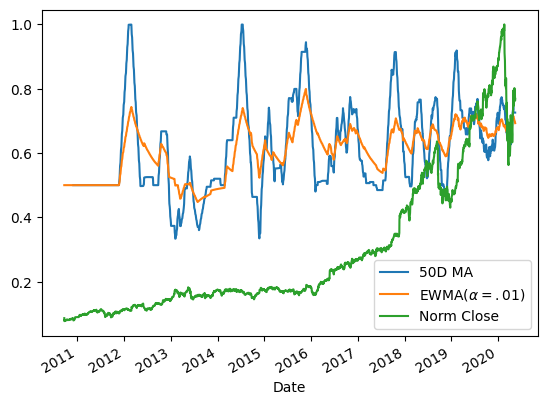

In [67]:
close = pl.col("sentiment")
df_join.select(
    [
        pl.col("Date"),
        #close.alias("Raw"),
        close.rolling_mean(50).alias("50D MA"),
        #close.alias("Expanding Average").cum_sum() / (close.cum_count() + 1),
        close.ewm_mean(alpha=0.01).alias("EWMA($\\alpha=.01$)"),
        pl.col("Norm Close").alias("Norm Close"),
    ]
).to_pandas().set_index("Date").plot()